<a href="https://colab.research.google.com/github/jianna4/skindisease-detector/blob/main/skindisease2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
syedalinaqvi_augmented_skin_conditions_image_dataset_path = kagglehub.dataset_download('syedalinaqvi/augmented-skin-conditions-image-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_285.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_1.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_217.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_380.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_198.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_353.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_145.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_328.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_326.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczema_281.jpg
/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions/Eczema/Eczem

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout ,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import json

In [ ]:
# Set your dataset directory
dataset_dir = '/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions'#insert yours

# Load the dataset
dataset = image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)


Found 2394 files belonging to 6 classes.


In [ ]:
# Split dataset
train_size = 0.8
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_batches = int(train_size * total_batches)
train_dataset = dataset.take(train_batches)
test_dataset = dataset.skip(train_batches)
val_size = 0.1
val_batches = int(val_size * total_batches)
validation_dataset = test_dataset.take(val_batches)
test_dataset = test_dataset.skip(val_batches)

# Prefetch to improve performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
model = tf.keras.models.Sequential([
     # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001),
           input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.4),                 # VERY IMPORTANT
    Dense(6, activation='softmax')
])

# --- CALLBACKS ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # reduce LR by 50%
    patience=2,        # if val_loss doesn't improve for 2 epochs
    min_lr=1e-10,
    verbose=1
)

# Compile the model
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,       # 👈 PUT EPOCHS HERE
    batch_size=32,
    callbacks=[early_stop, reduce_lr]    # 👈 ADD CALLBACKS HERE
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.3013 - loss: 2.4928 - val_accuracy: 0.3304 - val_loss: 1.7469 - learning_rate: 1.0000e-05
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6417 - loss: 1.0404 - val_accuracy: 0.4866 - val_loss: 1.3711 - learning_rate: 1.0000e-05
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.7303 - loss: 0.7889 - val_accuracy: 0.6562 - val_loss: 1.0068 - learning_rate: 1.0000e-05
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7810 - loss: 0.6542 - val_accuracy: 0.7143 - val_loss: 0.8331 - learning_rate: 1.0000e-05
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8419 - loss: 0.4771 - val_accuracy: 0.7991 - val_loss: 0.6430 - learning_rate: 1.0000e-05
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8601 - loss: 0.4147 - val_accuracy: 0.7857 - val_loss: 0.6446 - learning_rate: 1.0000e-05
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8952 - loss: 0.

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

# Save the model after evaluation

model.save("your_model.keras",include_optimizer=False)

print("Model saved as '/kaggle/working/your_model.keras")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8220 - loss: 0.6888
Test Loss: 0.5585214495658875
Test Accuracy: 0.843999981880188
Model saved as '/kaggle/working/your_model.keras


In [ ]:


# Save the training history to a JSON file
history_dict = history.history
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)
print("Training history saved as training_history.json")


Training history saved as training_history.json


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Classification Report:
              precision    recall  f1-score   support

        Acne       0.73      0.82      0.77        39
   Carcinoma       0.85      0.93      0.89        44
      Eczema       0.83      0.76      0.79        38
   Keratosis       0.76      0.88      0.81        42
       Milia       0.91      0.79      0.85        38
     Rosacea       0.93      0.78      0.84        49

    accuracy                           0.83       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.84      0.83      0.83       250

Confusion Matrix:
[[32  3  2  0  0  2]
 [ 0 41  0  3  0  0]
 [ 3  0 29  4  1  1]
 [ 0  3  1 37  1  0]
 [ 2  1  2  3 30  0]
 [ 7 

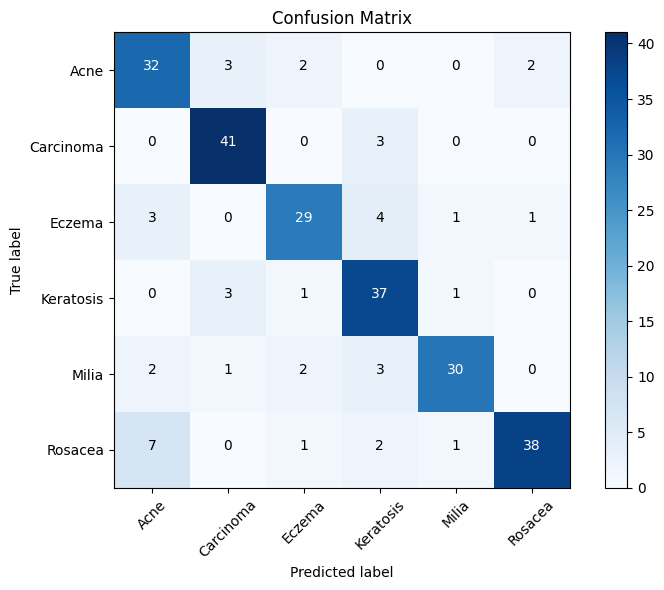

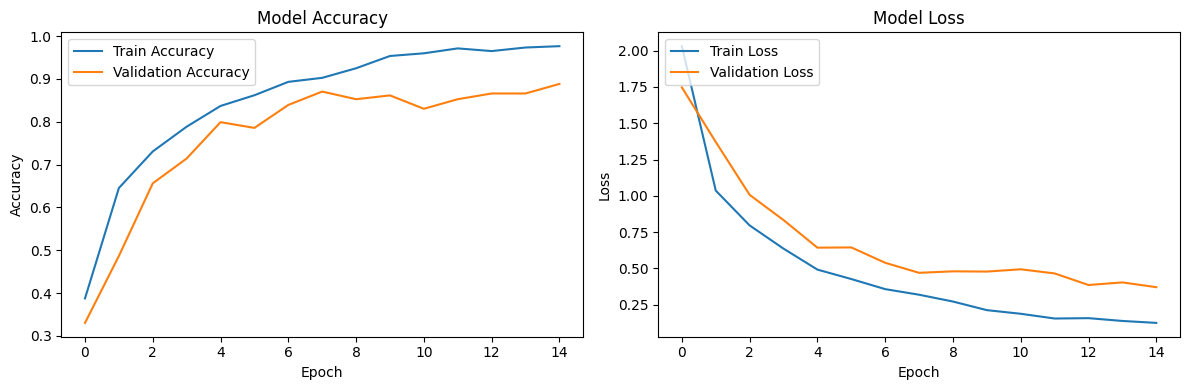

In [ ]:
# Generate predictions and create classification report
y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.class_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), ha="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=dataset.class_names, title='Confusion Matrix')
plt.show()

# Plot accuracy and loss curves
def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot training curves
plot_training_curves(history_dict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


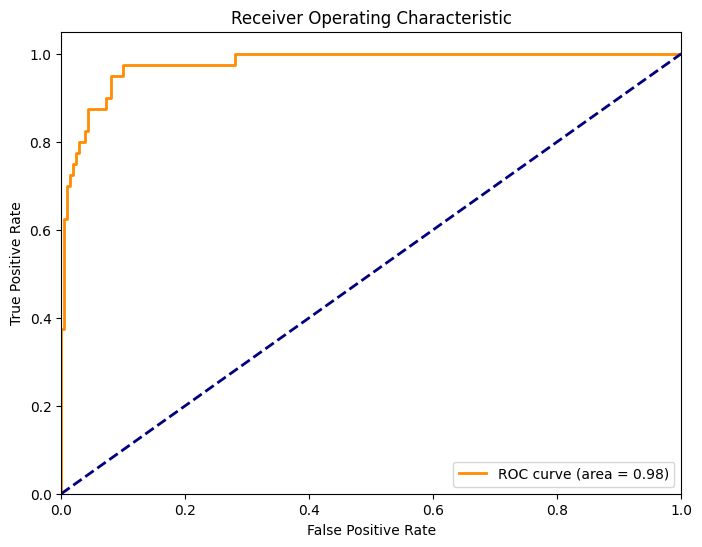

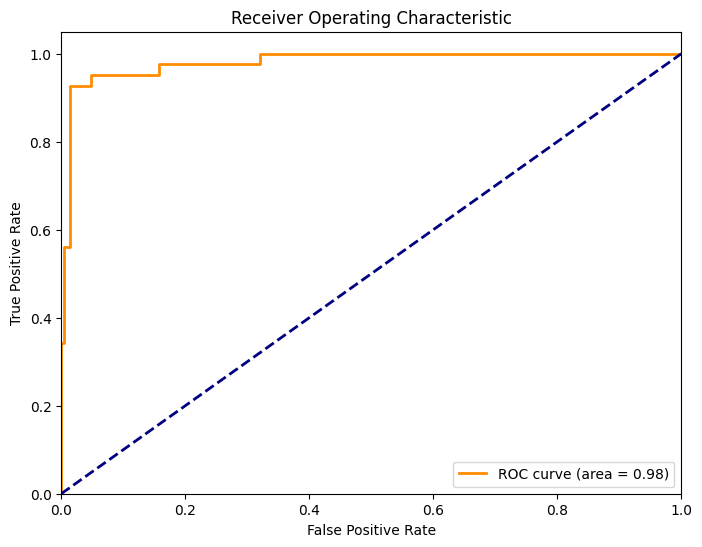

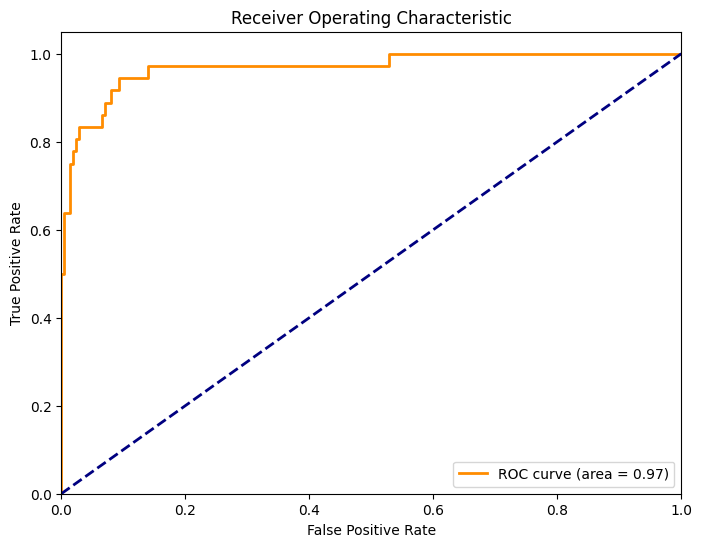

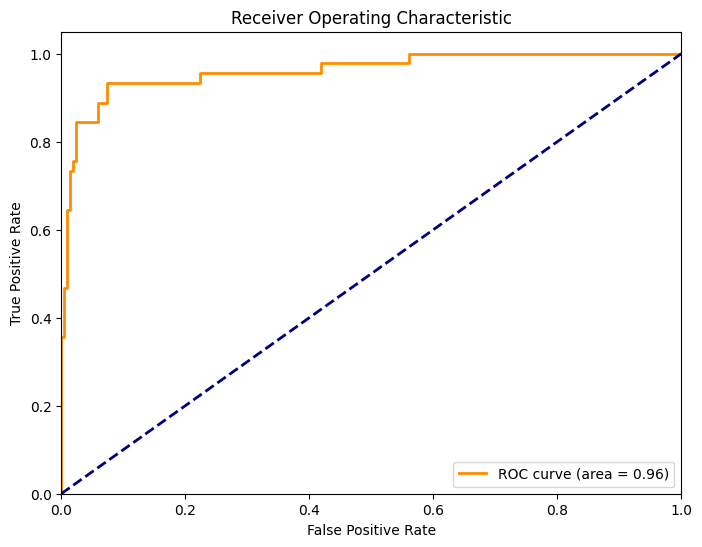

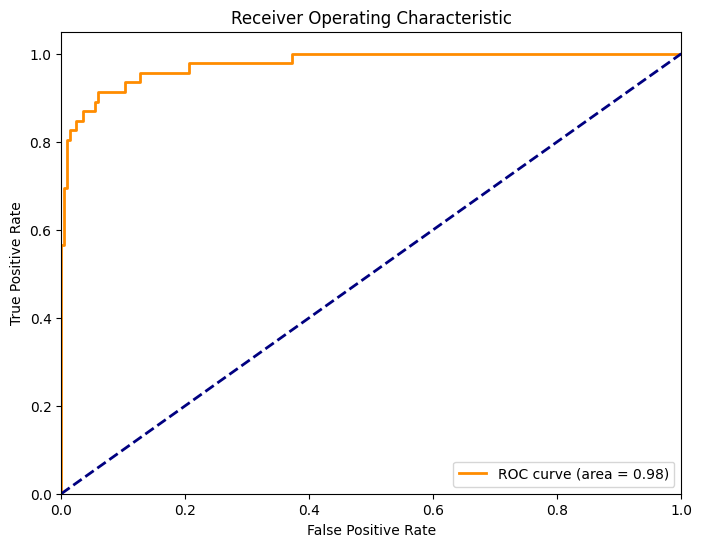

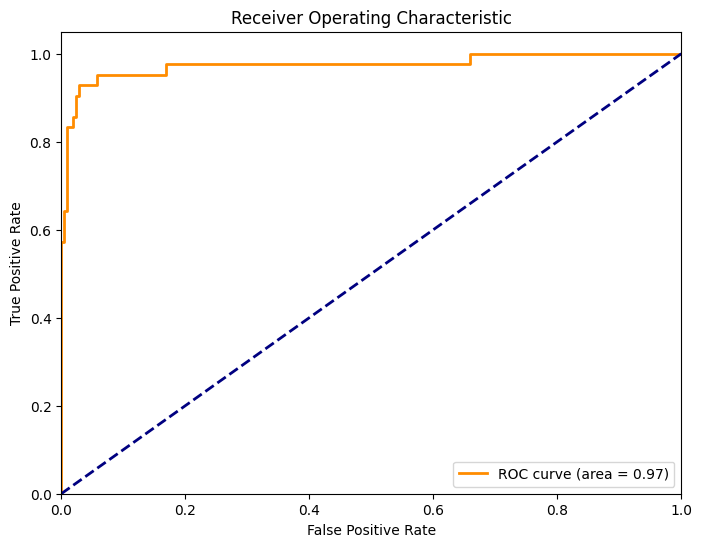

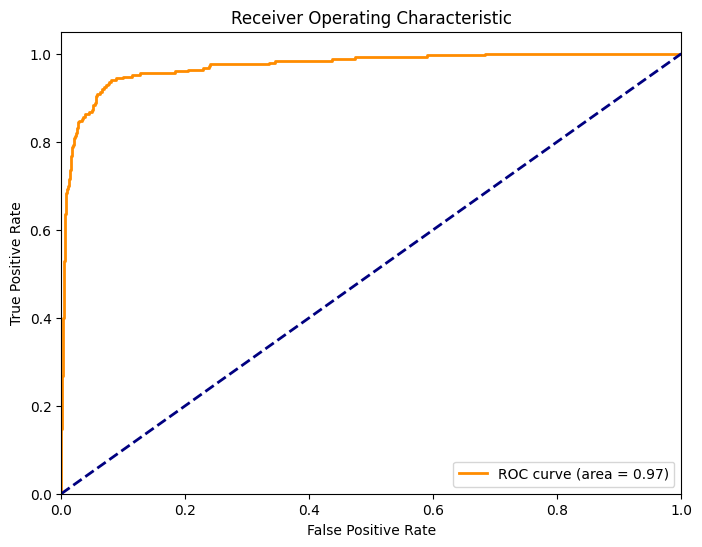

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to plot ROC curve for each class
def plot_roc_curve(fpr, tpr, auc, class_names):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Convert labels to one-hot encoding for ROC curve
y_true_one_hot = []
y_pred_probs = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true_one_hot.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_true_one_hot = label_binarize(y_true_one_hot, classes=np.arange(len(dataset.class_names)))
y_pred_probs = np.array(y_pred_probs)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(dataset.class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(len(dataset.class_names)):
    plot_roc_curve(fpr[i], tpr[i], roc_auc[i], dataset.class_names)

# Optionally, plot a macro-average ROC curve
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_probs.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plot_roc_curve(fpr["macro"], tpr["macro"], roc_auc["macro"], ["Macro Average"])
